In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.8.0
2.8.0


In [4]:
# Use the ! prefix to run shell commands in Jupyter notebook
!conda init
!conda activate ai_lab
!conda install -c conda-forge libsndfile python-soundfile

no change     /opt/anaconda3/condabin/conda
no change     /opt/anaconda3/bin/conda
no change     /opt/anaconda3/bin/conda-env
no change     /opt/anaconda3/bin/activate
no change     /opt/anaconda3/bin/deactivate
no change     /opt/anaconda3/etc/profile.d/conda.sh
no change     /opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /opt/anaconda3/shell/condabin/Conda.psm1
no change     /opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /opt/anaconda3/lib/python3.13/site-packages/xontrib/conda.xsh
no change     /opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/parkjoehyun/.bash_profile
No action taken.

CondaError: Run 'conda init' before 'conda activate'

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
failedg environment: / 

PackagesNotFoundError: The following packages are not available from current channels:

  - python-soundfile

Current channels:

  -

In [12]:
%pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os, glob, subprocess, shutil, tempfile
import torch
import torchaudio
import matplotlib.pyplot as plt

def ensure_ffmpeg():
    if shutil.which("ffmpeg") is None:
        raise RuntimeError("ffmpeg 설치 필요: 터미널에서 `brew install ffmpeg` 실행")

def convert_to_wav_if_needed(path: str) -> str:
    """입력 파일이 wav가 아니면 ffmpeg으로 wav 변환"""
    ext = os.path.splitext(path)[1].lower()
    if ext == ".wav":
        return path
    ensure_ffmpeg()
    wav_path = os.path.splitext(path)[0] + ".wav"
    if not os.path.exists(wav_path):
        cmd = ["ffmpeg", "-y", "-i", path, wav_path]
        print("Converting:", " ".join(cmd))
        subprocess.run(cmd, check=True)
    return wav_path

def pick_first_audio_file(data_dir="./audio_dataset") -> str:
    files = sorted(
        glob.glob(os.path.join(data_dir, "*.wav")) +
        glob.glob(os.path.join(data_dir, "*.m4a")) +
        glob.glob(os.path.join(data_dir, "*.mp3"))
    )
    if not files:
        raise FileNotFoundError(f"{data_dir} 폴더에 오디오 파일이 없습니다.")
    return files[0]



In [5]:
DATA_DIR = "./audio_dataset"
src_path = pick_first_audio_file(DATA_DIR)
wav_path = convert_to_wav_if_needed(src_path)


In [3]:
import librosa

wav_path = "./audio_dataset/095522039.m4a"   # 데이터셋 중 하나 지정함
y, sr = librosa.load(wav_path, sr=None)      # sr=None → 원본 SR 유지
waveform = torch.tensor(y).unsqueeze(0)      # [1, time] 형태
sample_rate = sr

print(f"Loaded {wav_path}, shape={tuple(waveform.shape)}, sr={sample_rate}")


Loaded ./audio_dataset/095522039.m4a, shape=(1, 176400), sr=44100


/var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/ipykernel_32888/3391898482.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path, sr=None)      # sr=None → 원본 SR 유지
/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [6]:
waveform, sample_rate = torchaudio.load(wav_path)
print(f"Loaded: {wav_path}")
print(f" - shape={tuple(waveform.shape)} | sr={sample_rate}")
print("Metadata:", torchaudio.info(wav_path))

Loaded: ./audio_dataset/095522039.wav
 - shape=(1, 177152) | sr=44100
Metadata: AudioMetaData(sample_rate=44100, num_frames=177152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/ipykernel_42479/2548748403.py:4: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be re

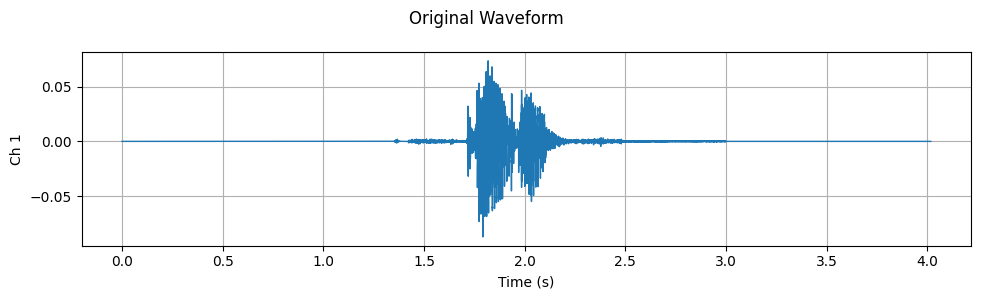

In [10]:
def plot_waveform(waveform, sample_rate, title="Waveform"):
    wf = waveform.numpy()
    num_channels, num_frames = wf.shape
    t = torch.arange(num_frames) / sample_rate
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 3))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(t, wf[c], linewidth=1)
        axes[c].grid(True)
        axes[c].set_ylabel(f"Ch {c+1}")
    fig.suptitle(title)
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

plot_waveform(waveform, sample_rate, "Original Waveform")

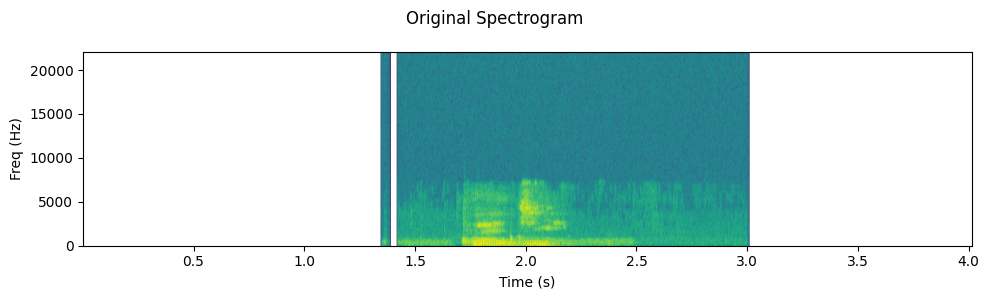

In [11]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    wf = waveform.numpy()
    num_channels, _ = wf.shape
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 3))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(wf[c], Fs=sample_rate)
        axes[c].set_ylabel("Freq (Hz)")
    fig.suptitle(title)
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

plot_specgram(waveform, sample_rate, "Original Spectrogram")

In [13]:
from IPython.display import Audio

Audio(waveform.numpy()[0], rate=sample_rate)

In [15]:
waveform, sample_rate = torchaudio.load("./audio_dataset/095522039.wav")

def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

# 저장 예제
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)   # wav로 저장
    inspect_file(path)

----------
Source: /var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/tmp5_v6uya3/save_example_default.wav
----------
 - File size: 708688 bytes
 - AudioMetaData(sample_rate=44100, num_frames=177152, num_channels=1, bits_per_sample=32, encoding=PCM_F)



/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/ipykernel_42479/38401397.py:8: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(

In [16]:
# 16bit PCM 저장
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: /var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/tmp25_deoug/save_example_PCM_S16.wav
----------
 - File size: 354348 bytes
 - AudioMetaData(sample_rate=44100, num_frames=177152, num_channels=1, bits_per_sample=16, encoding=PCM_S)



/var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/ipykernel_42479/38401397.py:8: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(f" - {torchaudio.info(path)}")


In [18]:
# FLAC 저장 예제
formats = ["flac"]  # 필요한 포맷만 남김
with tempfile.TemporaryDirectory() as tempdir:
    for fmt in formats:
        path = f"{tempdir}/save_example.{fmt}"
        torchaudio.save(path, waveform, sample_rate, format=fmt)
        inspect_file(path)

----------
Source: /var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/tmpt8_gha0_/save_example.flac
----------
 - File size: 30244 bytes
 - AudioMetaData(sample_rate=44100, num_frames=177152, num_channels=1, bits_per_sample=16, encoding=FLAC)



/var/folders/_8/5nkrzgyx6xdgk2_9b4gmkdgc0000gn/T/ipykernel_42479/38401397.py:8: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(f" - {torchaudio.info(path)}")


In [21]:
# 메모리에 저장 (BytesIO)
import io

buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")
buffer_.seek(0)
print(buffer_.read(16))

b'RIFFH\xd0\n\x00WAVEfmt '
